In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import tree
import sklearn.linear_model as LM
from sklearn import ensemble
from sklearn.datasets import make_classification,make_circles,make_regression
from sklearn.metrics import zero_one_loss,r2_score,mean_squared_error

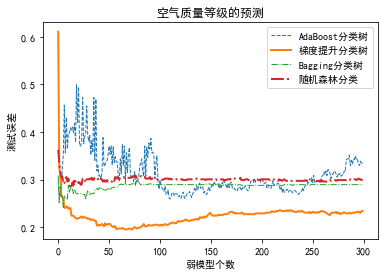

In [3]:
data=pd.read_excel('北京市空气质量数据.xlsx')
data=data.replace(0,np.NaN)
data=data.dropna()
X=data.iloc[:,3:-1]
Y=data['质量等级']
Y=Y.map({'优':'1','良':'2','轻度污染':'3','中度污染':'4','重度污染':'5','严重污染':'6'})
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.70, random_state=123)

B=300
dt_stump = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
TestErrAdaB=np.zeros((B,))
adaBoost = ensemble.AdaBoostClassifier(base_estimator=dt_stump,n_estimators=B,random_state=123)
adaBoost.fit(X_train,Y_train)
for b,Y_pred in enumerate(adaBoost.staged_predict(X_test)):
    TestErrAdaB[b]=zero_one_loss(Y_test,Y_pred) 

TestErrGBRT=np.zeros((B,))
GBRT=ensemble.GradientBoostingClassifier(loss='deviance',n_estimators=B,max_depth=3,min_samples_leaf=1,random_state=123)
GBRT.fit(X_train,Y_train)
for b,Y_pred in enumerate(GBRT.staged_predict(X_test)):
    TestErrGBRT[b]=zero_one_loss(Y_test,Y_pred) 

TestErrBag=np.zeros((B,)) 
TestErrRF=np.zeros((B,))
for b in np.arange(B):
    Bag=ensemble.BaggingClassifier(base_estimator=dt_stump,n_estimators=b+1,oob_score=True,random_state=123,bootstrap=True)
    Bag.fit(X_train,Y_train)
    TestErrBag[b]=1-Bag.score(X_test,Y_test)
    RF=ensemble.RandomForestClassifier(max_depth=3,n_estimators=b+1,oob_score=True,random_state=123,
                                       bootstrap=True,max_features="auto")
    RF.fit(X_train,Y_train)
    TestErrRF[b]=1-RF.score(X_test,Y_test)

plt.plot(np.arange(B),TestErrAdaB,linestyle='--',label="AdaBoost分类树",linewidth=1)
plt.plot(np.arange(B),TestErrGBRT,linestyle='-',label="梯度提升分类树",linewidth=2)
plt.plot(np.arange(B),TestErrBag,linestyle='-.',label="Bagging分类树",linewidth=1)
plt.plot(np.arange(B),TestErrRF,linestyle='-.',label="随机森林分类",linewidth=2)
plt.title("空气质量等级的预测")
plt.xlabel("迭代次数")
plt.ylabel("测试误差")
plt.legend()   
    

说明：基于空气质量监测数据，采用集成学习的不同策略预测空气质量等级，并进行对比。
1、首先利用旁置法划分训练集和测试集。
2、以树深度等于3的分类树作为集成学习器，分别建立基于提升策略的分类树和梯度提升分类树，并计算迭代次数增加至300过程中的测试误差。
3、分别采用袋装策略和随机森林建立分类模型，并计算迭代次数增加至300过程中的测试误差。
4、对计算结果绘制折线图。图形显示，梯度提升树的测试误差最低，预测效果最为理想。